# SENTIMENT ANALYSIS


**Import Libraries**

In [286]:
##Basic ML Libraries

import pandas as pd 
import numpy as np 

##Model evaluation

from sklearn.metrics import accuracy_score, classification_report

##Visualization

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

##Data pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

##Building model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [314]:
# Step 1: Load the train and test datasets
train_data = pd.read_csv("C:/Users/v-dmanasa/Downloads/train_Reviews.csv")
test_data = pd.read_csv("C:/Users/v-dmanasa/Downloads/test_Reviews.csv")

In [315]:
train_data.head(5)

,Name,On a Scale of 1-5 Rate the Place,A Detailed Review of the Place
0,Prakash,4.0,Awesome experience with a friend who was in a ...
1,Prashanth,3.0,It was a good visit to the Zoo. My son loved a...
2,Ashwin J,3.0,Have been wanting to visit this place since th...
3,Amit Khare,2.0,It was too overcrowded even to have a look pro...
4,ChennaiShaji,4.0,A land mark which you cannot miss while in the...


In [316]:
test_data.head(5)

,Name,A Detailed Review of the Place
0,OctOriental,"Great hub of hanging out, boating, eating and ..."
1,Konganapally Laasya,It’s good and it was so long ago that I comple...
2,ShubH GhosH,Must be an imposing structure but really cant ...
3,Deepyayan Ghosh,Hussain Sagar Lake adds a good view but from a...
4,Shalini N,The temple is situated on a hilltop. The view...


`Name` column doesn't provide much information here so we will drop the entire column from both dataset

In [317]:
train_data.drop('Name',axis=1,inplace=True)
test_data.drop('Name',axis=1,inplace=True)

Dropping the `name column` in train dataset since it doesn't provide much information and tends to decrease the accuracy in our model.

**DATA UNDERSTANDING**

In [318]:
train_data.shape

(706, 2)

In [319]:
test_data.shape

(348, 1)

There are 705 rows and 3 variable in train dataset.

In [320]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   On a Scale of 1-5 Rate the Place  676 non-null    float64
 1   A Detailed Review of the Place    705 non-null    object 
dtypes: float64(1), object(1)
memory usage: 11.2+ KB


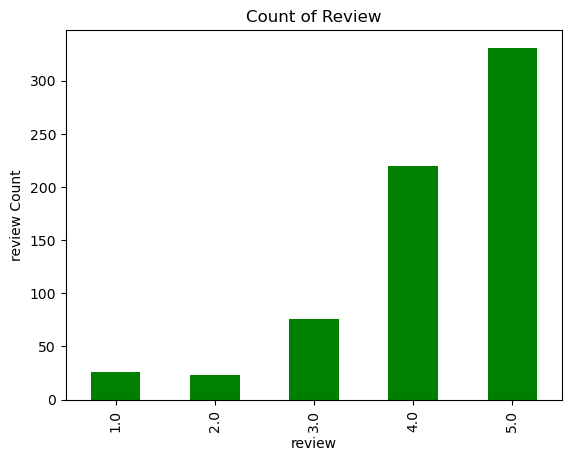

In [321]:
# A quick visualization of the rating to see the distribution


train_data['On a Scale of 1-5 Rate the Place'].value_counts().sort_index().plot(kind='bar', color= 'green')
plt.ylabel('review Count')
plt.xlabel('review')
plt.title('Count of Review');

`BAR PLOT` shows the distribution of each ratings

**DATA MANIPULATION**

In [322]:
train_data.isnull().sum()

On a Scale of 1-5 Rate the Place    30
A Detailed Review of the Place       1
dtype: int64

In [323]:
# Impute missing values with the mode
mode = train_data['On a Scale of 1-5 Rate the Place'].mode()[0]
train_data['On a Scale of 1-5 Rate the Place'].fillna(mode, inplace=True)

# Remove rows with missing values.
train_data.dropna(subset=['A Detailed Review of the Place'], inplace=True)



In [324]:
train_data.isnull().sum()

On a Scale of 1-5 Rate the Place    0
A Detailed Review of the Place      0
dtype: int64

In [325]:
test_data.isnull().sum()

A Detailed Review of the Place    0
dtype: int64

There are missing values in On a Scale of 1-5 Rate the Place column which is further imputed with mode value

The column - A Detailed Review of the Place has only one missing value which can be dropped off from the dataset.

**Functions to create tokenizer and clean/process the text column**

In [326]:
stemmer  = SnowballStemmer(language='english') #setup for english language
stop_words = stopwords.words('english') # defining stop_words for english language
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies reviews
lemmatizer = WordNetLemmatizer()

In [327]:
#function to create tokenizer
def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text)]

In [328]:
#  Lets test the tokenize function
tokenize("my name is")

['my', 'name', 'is']

**Text Pre-processing**

The dataset has 1 text column which is the `A Detailed Review of the Place` column. Now, let's process the text in the `A Detailed Review of the Place ` column as follows.

First, strip all punctuations and html tags and extract only the texts;

Second, convert text to lowercase;

Finally, convert all phrases to tokens that our model will use.

In [329]:
# Initialize the WordNet lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess a single phrase
def data_preprocess(phrase):
    # Removing HTML tags
    phrase = re.sub('<.*?>', '', phrase)
    # Taking only alphanumeric characters
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    # Converting to lowercase
    phrase = phrase.lower()
    # Tokenizing the phrase
    tokens = nltk.word_tokenize(phrase)
    # Removing stop words and lemmatizing
    phrase = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Joining the words back into a string
    phrase = ' '.join(phrase)
    return phrase

# Applying the preprocessing function to the DataFrame
train_data['Preprocessed_phrase'] = train_data['A Detailed Review of the Place'].apply(data_preprocess)

# Displaying the DataFrame
train_data.head()


,On a Scale of 1-5 Rate the Place,A Detailed Review of the Place,Preprocessed_phrase
0,4.0,Awesome experience with a friend who was in a ...,awesome experience friend hospital cancer late...
1,3.0,It was a good visit to the Zoo. My son loved a...,good visit zoo son loved could spot animal gre...
2,3.0,Have been wanting to visit this place since th...,wanting visit place since time came hyderabad ...
3,2.0,It was too overcrowded even to have a look pro...,overcrowded even look properly went evening ti...
4,4.0,A land mark which you cannot miss while in the...,land mark miss twin city hyderabad secunderaba...


In [330]:
# Applying the preprocessing function to the DataFrame
test_data['Preprocessed_phrase'] = test_data['A Detailed Review of the Place'].apply(data_preprocess)

# Displaying the DataFrame
test_data.head()

,A Detailed Review of the Place,Preprocessed_phrase
0,"Great hub of hanging out, boating, eating and ...",great hub hanging boating eating recreation bo...
1,It’s good and it was so long ago that I comple...,good long ago completely forgot experience go ...
2,Must be an imposing structure but really cant ...,must imposing structure really cant enjoy view...
3,Hussain Sagar Lake adds a good view but from a...,hussain sagar lake add good view distance part...
4,The temple is situated on a hilltop. The view...,temple situated hilltop view top beautiful esp...


A column `Preprocssed_phrase` is created in both the train and test datset which will be used for prediction.

**DATA MODELING**

**Lets split the data into Train and Test(80|20)**

In [331]:
from sklearn.model_selection import train_test_split

train_df = train_data.copy()
y = train_df['On a Scale of 1-5 Rate the Place'].values
train_df.drop(['On a Scale of 1-5 Rate the Place'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, stratify=y)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (564, 2) (564,)
Test data: (141, 2) (141,)


**Vectorizing the Text Data**

In the next step, we will transfer the pre-processed phrase column to a vector representation. The vector representations allows us to train a model based on numerical representations. In this case, we will use CountVectorizer.

In [349]:
vectorizer = CountVectorizer()

X_train_phrase_bow = vectorizer.fit_transform(X_train['Preprocessed_phrase'])
X_test_phrase_bow = vectorizer.transform(X_test['Preprocessed_phrase'])

print('X_train_phrase_bow shape: ', X_train_phrase_bow.shape)
print('X_test_phrase_bow  shape: ', X_test_phrase_bow .shape)

X_train_phrase_bow shape:  (564, 3151)
X_test_phrase_bow  shape:  (141, 3151)


**Model Building**


Naive Bayes

**Let's train a Multinomial Naive Bayes classifier and evaluate its performance**

In [350]:
clf = MultinomialNB()
clf.fit(X_train_phrase_bow, y_train)

y_pred = clf.predict(X_test_phrase_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred)) 

Test Accuracy:  0.624113475177305


**Support vector classification**

In [337]:
svc = SVC()
svc.fit(X_train_phrase_bow, y_train)

y_pred = svc.predict(X_test_phrase_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred)) 

Test Accuracy:  0.574468085106383


**Building a model with Naive Bayes' Term Frequency-Inverse Document Frequency (TFIDF)**

In [341]:
vectorizer = TfidfVectorizer()

X_train_phrase_tfidf = vectorizer.fit_transform(X_train['Preprocessed_phrase'])
X_test_phrase_tfidf = vectorizer.transform(X_test['Preprocessed_phrase'])

print('X_train_phrase_tfidf shape: ', X_train_phrase_tfidf.shape)
print('X_test_phrase_tfidf shape: ', X_test_phrase_tfidf.shape)

X_train_phrase_tfidf shape:  (564, 3151)
X_test_phrase_tfidf shape:  (141, 3151)


In [342]:
clf = MultinomialNB()
clf.fit(X_train_phrase_tfidf, y_train)

y_pred = clf.predict(X_test_phrase_tfidf) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred)) 

Test Accuracy:  0.5531914893617021


After model evaluation we have seen the `Multinomial Naive Bayes classifier` with `Count vectorizer` is perfoming well. 

Further we are using that model to predict the values on the test data

In [351]:
#vectorizing the Preprocessed_phrase column in test data
vectorizer = CountVectorizer()

X_train_phrase_bow = vectorizer.fit_transform(X_train['Preprocessed_phrase'])
test_data_phrase_cv = vectorizer.transform(test_data['Preprocessed_phrase'])

print('X_train_phrase_tfidf shape: ', X_train_phrase_bow.shape)
print('test_data_phrase_tfidf shape: ',test_data_phrase_cv.shape)

X_train_phrase_tfidf shape:  (564, 3151)
test_data_phrase_tfidf shape:  (348, 3151)


In [352]:
y_pred = clf.predict(test_data_phrase_cv)

In [353]:
# Step 9: Save predictions to test_data DataFrame
test_data['Predicted_Rating'] = y_pred

In [354]:
test_data.head()

,A Detailed Review of the Place,Preprocessed_phrase,Predicted_Rating
0,"Great hub of hanging out, boating, eating and ...",great hub hanging boating eating recreation bo...,4.0
1,It’s good and it was so long ago that I comple...,good long ago completely forgot experience go ...,5.0
2,Must be an imposing structure but really cant ...,must imposing structure really cant enjoy view...,5.0
3,Hussain Sagar Lake adds a good view but from a...,hussain sagar lake add good view distance part...,4.0
4,The temple is situated on a hilltop. The view...,temple situated hilltop view top beautiful esp...,4.0


In [355]:
test_data.Predicted_Rating.value_counts()

5.0    245
4.0     88
3.0      9
2.0      3
1.0      3
Name: Predicted_Rating, dtype: int64

**Conclusion**

The Multinomial Naive Bayes classifier(CV) model performed better than the SVC and the Naive Bayes(TFIDF) with accuracy of 62%. This could be due to the characteristics of the dataset, including the distribution of classes and the balance between classes.